# Model Selection - Regressors

The goal of this notebook is to compare regression algorithms in predicting the changes in the the number of residential units under FAIR Plan policy and, as a secondary target, the total exposure acquired by the program.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

sns.set_style('whitegrid')
pd.options.display.float_format = '{:.5f}'.format

CLEAN_DATA_DIR = Path('../clean_data/')

In [2]:
df = pd.read_csv(CLEAN_DATA_DIR / 'engineered_dataset.csv', index_col=0)
df.sample(3)

,FAIR Plan Units,% FAIR Plan Units,Total Exposure ($),% Change - Claims (Fire and Smoke),% Change - Earned Premiums,% Change - Expiring Policies,% Change - Losses (Fire and Smoke),% Change - New Policies,% Change - Nonrenewed Policies,% Change - Nonrenewed Policies (by Company),...,Growth in Losses to All Disasters 10yr Ratio,Growth in Losses to Fire Disasters 3yr Ratio,Growth in Losses to Fire Disasters 5yr Ratio,Growth in Losses to Fire Disasters 10yr Ratio,Premium to Exposure Ratio,Nonrenewal Rate,Loss Burden per Unit,Loss Burden per Exposure,Premium Adequacy,Renewal Resilience
ZIP Code,,,,,,,,,,,,,,,,,,,,,
90201,1116.00000,0.08874,283630711.00000,0.19048,0.27585,0.01230,0.46274,0.15615,0.17308,0.37379,...,0.02722,0.09255,0.05784,0.04207,1565.01288,0.07770,365.91698,365.91698,4.27696,0.92230
93675,130.00000,0.11949,72829709.00000,0.14286,0.27136,0.03652,-0.55589,-0.21951,0.14493,-0.31818,...,-0.18530,-0.27794,-0.27794,-0.18530,4951.17923,0.14545,967.38603,967.38603,5.11810,0.85455
90064,47.00000,0.00746,22512477.00000,-0.40000,0.29764,0.01961,6.69559,0.15641,0.22982,-0.04396,...,2.23186,3.34779,3.34779,2.23186,6885.43052,0.09784,546.71320,546.71320,12.59423,0.90216


## Train-test split

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
df_train, df_test = train_test_split(
    df,
    test_size=.2,
    random_state=13348,
    shuffle=True
)

## Evaluation metrics

We will use mean squared error (MSE) as our main evaluation metric, but we will also compute RMSE and MAE. 

For model predicting total exposure, we also will include an additional metric called 'global_difference'. This metric calculates, in USD, the absolute difference between the predicted total exposure and the actual one.

In [5]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, root_mean_squared_error as rmse

eval = pd.DataFrame(columns=['mse', 'rmse', 'mae', 'global_diff'])

In [6]:
def calculate_diff(y_true, preds):
    return round(abs((sum(y_true)-sum(preds)) / (1000 * 1000)), 2)

def calculate_metrics(y_true, preds, fix_pct=True):
# hack to set to zero percentages below 0 for unbounded regressors
    if fix_pct:
        preds = np.where(np.array(preds) < 0, 0, preds)

    return [mse(y_true, preds), 
            rmse(y_true, preds), 
            mae(y_true, preds), 
            calculate_diff(y_true, preds),
            sum(y_true) / (1000 * 1000)]

def create_eval_table(vals):
    cols = ['Feature Set', 'Target Variable' ,'Model', 'MSE', 'RMSE', 'MAE', 'Global Diff', 'Total Val']
    res = pd.DataFrame(vals, columns=cols)
    return res.groupby(['Feature Set', 'Target Variable' ,'Model']).mean()    

def plot_metrics(eval_table, feature_set, metrics=['RMSE', 'MAE']):
    eval_table.loc[feature_set].droplevel(0).plot.bar(y=metrics, rot=0, width=.8, figsize=(8,3))

    plt.xlabel(None)
    plt.title(f'Model Comparison\n (Feature set: {feature_set})')
    
    plt.show()

## Feature Selections

Based on our EDA, we selected a series of feature sets to train and benchmark our models, which is described below.

In [7]:
# use the format
# 'feature_set_name': (target, [features]) 
targets = df.columns[:3] #['FAIR Plan Units', '% FAIR Plan Units', 'Total Exposure ($)']
all_features = df.columns[3:]

main_features = ['Renewal Resilience', 'Median Gross Rent ($)',
                'Avg Median Income', 'Zillow Mean Home Value ($)',
                'Fire Disasters 1y', 'Growth in Losses to All Disasters 5yr Ratio',
                'Premium to Exposure Ratio', 'Avg % White-only Pop',
                'Nonrenewal Rate', '% Change - Earned Premiums']
main_features = ['Renewal Resilience', 
                'Median Gross Rent ($)',
                'Avg Median Income', 
                'Zillow Mean Home Value ($)',
                'Growth in Losses to All Disasters 5yr Ratio',
                'Premium to Exposure Ratio',
                '% Change - Earned Premiums']

exposure_features = ['Zillow Mean Home Value ($)',
                    'Median Owner Cost ($)', 'Premium to Exposure Ratio',
                    'Nonrenewal Rate', '% Change - Earned Premiums']

# Rates of Change
dynamic_features = ['% Change - Claims (Fire and Smoke)',
                    '% Change - Earned Premiums',
                    '% Change - Losses (Fire and Smoke)',
                    '% Change - Zillow Home Value',
                    '% Change Median Income',
                    'All Disasters 5y']

feature_sets = {
    'main_n_fair': (targets[0], main_features),
    'main_%_fair': (targets[1], main_features),
    'main_exposure': (targets[2], main_features),    
    'exposure_features': (targets[2], exposure_features),    
    'dynamic_%_fair': (targets[1], dynamic_features)
}


## Model Specification

In [8]:
# baseline model with the mean
def baseline_model(y_train, y_test):
    mu_y = y_train.mean()
    preds = [mu_y] * len(y_test)
    return calculate_metrics(y_test, preds)

In [9]:
# linear regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [10]:
# knn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=4))
])

# function to find the best K for a given training set
def best_k(y_train, y_test, X_train, X_test, k_upper=20, plot=True):
    rmses = []
    for k in range(1, k_upper):
        knn_pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsRegressor(n_neighbors=k))
        ])
        
        # fitting and prediction
        knn_pipe.fit(X_train, y_train)
        preds = knn_pipe.predict(X_test)

        # calculating and saving mse
        rmses.append((k, mse(y_test, preds)))

    # plot graph        
    if plot:
        plt.figure(figsize=(6,4))

        plt.plot(np.array(rmses)[:, 0], np.array(rmses)[:, 1])

        plt.ylabel('MSE')
        plt.xlabel('k')

        plt.show()

    best_k = rmses[int(np.where(np.array(rmses)[:, 1] == np.array(rmses)[:, 1].min())[0])][0]
    return best_k


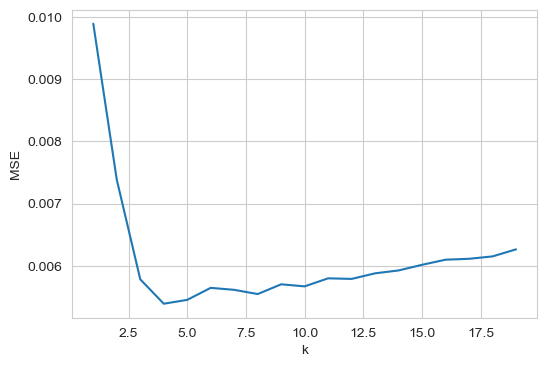

C:\Users\lbarleta\AppData\Local\Temp\ipykernel_107376\3612865308.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  best_k = rmses[int(np.where(np.array(rmses)[:, 1] == np.array(rmses)[:, 1].min())[0])][0]


4

In [11]:
# for feature set 'main_%_fair'
feature_set = feature_sets['main_%_fair']

y_train, y_test = df_train[feature_set[0]], df_test[feature_set[0]]
X_train, X_test = df_train[feature_set[1]], df_test[feature_set[1]]

best_k(y_train, y_test, X_train, X_test)

In [12]:
# gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

grad_bost = GradientBoostingRegressor(
    learning_rate=.1,
    n_estimators=1000,
    max_depth=1
)

In [13]:
from xgboost import XGBRegressor

xgboost = XGBRegressor(
    learning_rate=.1,
    n_estimators=1000,
    max_depth=1
)

## Cross-validation

In [14]:
from sklearn.model_selection import KFold

models = [('Baseline (mean)', None),
          ('Linear Regression', lr), 
          ('kNN - 4', knn), 
          ('Gradient Boosting', grad_bost), 
          ('XGBoost', xgboost)]

kfold = KFold(n_splits = 5)

In [15]:
# function to run cross-validation in different feature sets
def run_cross_val(target, features, set=None):
    results = []

    for i, (train_index, test_index) in enumerate(kfold.split(df_train)):
        df_tt = df_train.iloc[train_index]
        df_ho = df_train.iloc[test_index]

        for j, model in enumerate(models):
            if model[0] == 'Baseline (mean)':
                eval = baseline_model(df_tt[target], df_ho[target])
            else:
                model[1].fit(df_tt[features], df_tt[target])
                preds = model[1].predict(df_ho[features])
                eval = calculate_metrics(df_ho[target], preds)

            results.append([set, target, model[0]] + eval)

    return results

In [16]:
# running cross-validation for all feature sets
vals = []

for feature_set, data in feature_sets.items():
    target = data[0]
    features = data[1]

    vals += run_cross_val(target, features, feature_set)

In [17]:


eval

,mse,rmse,mae,global_diff


In [18]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
eval_table = create_eval_table(vals)

# making it into millions of dollars\n",
millions = eval_table.loc[(['exposure_features', 'main_exposure']), ['RMSE', 'MAE']] / (1000 * 1000)
eval_table.loc[(['exposure_features', 'main_exposure']), ['RMSE', 'MAE']]  = millions

cols = ['Feature Set', 'Target Variable' ,'Model', 'MSE', 'RMSE', 'MAE', 'Global Diff', 'Total Val']
res = pd.DataFrame(vals, columns=cols)

# percentage of different in exposure predictions

eval_table['Pct Diff'] = eval_table['Global Diff'] / eval_table['Total Val']

eval_table

MSE  \
Feature Set       Target Variable    Model                                      
dynamic_%_fair    % FAIR Plan Units  Baseline (mean)                    0.010   
                                     Gradient Boosting                  0.006   
                                     Linear Regression                  0.006   
                                     XGBoost                            0.005   
                                     kNN - 4                            0.005   
exposure_features Total Exposure ($) Baseline (mean)   150420645315451296.000   
                                     Gradient Boosting 150282161393152704.000   
                                     Linear Regression 115950853062742608.000   
                                     XGBoost           116062203572173984.000   
                                     kNN - 4           102803714784903296.000   
main_%_fair       % FAIR Plan Units  Baseline (mean)                    0.010   
                                     Gradient Boosting                  0.003   
                                     Linear Regression                  0.004   
                                     XGBoost                            0.003   
                                     kNN - 4                            0.003   
main_exposure     Total Exposure ($) Baseline (mean)   150420645315451296.000   
                                     Gradient Boosting 146747924331992672.000   
                                     Linear Regression 112665995527865232.000   
                                     XGBoost           112971607676680224.000   
                                     kNN - 4           125370570695669344.000   
main_n_fair       FAIR Plan Units    Baseline (mean)               209516.771   
                                     Gradient Boosting             168676.690   
                                     Linear Regression             165255.670   
                                     XGBoost                       131717.584   
                                     kNN - 4                       162619.646   

                                                          RMSE     MAE  \
Feature Set       Target Variable    Model                               
dynamic_%_fair    % FAIR Plan Units  Baseline (mean)     0.098   0.057   
                                     Gradient Boosting   0.073   0.038   
                                     Linear Regression   0.074   0.042   
                                     XGBoost             0.070   0.037   
                                     kNN - 4             0.071   0.037   
exposure_features Total Exposure ($) Baseline (mean)   373.936 170.673   
                                     Gradient Boosting 373.431 147.143   
                                     Linear Regression 327.050 154.457   
                                     XGBoost           332.168 145.839   
                                     kNN - 4           305.248 128.010   
main_%_fair       % FAIR Plan Units  Baseline (mean)     0.098   0.057   
                                     Gradient Boosting   0.058   0.030   
                                     Linear Regression   0.063   0.039   
                                     XGBoost             0.055   0.030   
                                     kNN - 4             0.053   0.026   
main_exposure     Total Exposure ($) Baseline (mean)   373.936 170.673   
                                     Gradient Boosting 372.598 142.436   
                                     Linear Regression 322.508 154.286   
                                     XGBoost           328.267 143.156   
                                     kNN - 4           342.348 140.506   
main_n_fair       FAIR Plan Units    Baseline (mean)   451.798 222.706   
                                     Gradient Boosting 406.801 174.768   
                                     Linear Regression 398.948 203.663   
                                    

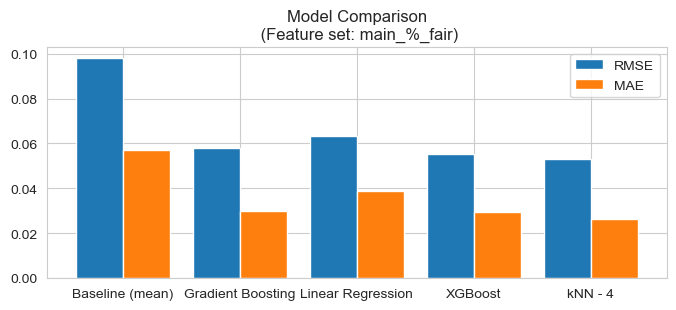

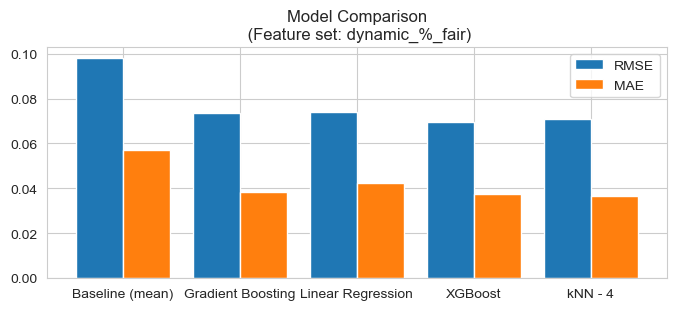

In [19]:
plot_metrics(eval_table, 'main_%_fair')
plot_metrics(eval_table, 'dynamic_%_fair')

## Final Validation

The model that performed best was the feature set "main_%_fair" using gradient boosting. Now let's retrain the model in the entire training data and perform final validation on the test set.

In [24]:
# the winner 
feature_set =  feature_sets['main_%_fair']

y_train, y_test = df_train[feature_set[0]], df_test[feature_set[0]]
X_train, X_test = df_train[feature_set[1]], df_test[feature_set[1]]

In [25]:
grad_bost.fit(X_train, y_train)
preds = grad_bost.predict(X_test)

res = pd.DataFrame({
        'baseline_model': baseline_model(y_train, y_test),
        'grad_bost': calculate_metrics(y_test, preds)
    }).T.iloc[:, :-2].rename({0: 'MSE', 1: 'RMSE', 2: 'MAE'}, axis=1)

res

,MSE,RMSE,MAE
baseline_model,0.015,0.123,0.064
grad_bost,0.005,0.067,0.034
